In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_score

from scipy.linalg import pinv2
from scipy.special import expit
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

import tensorflow as tf

tf.random.set_seed(42)
np.random.seed(42)

# 1. Implementação de uma Rede Neural Artificial feed forward de N camadas

In [11]:
class Camada():
    def __init__ (self, qtde_nosEntrada, qtde_nosSaida, taxa_aprendizado = 0.2, debug = True):
        
        self.debug = debug
        
        self.nosEntrada       = qtde_nosEntrada
        self.nosSaida         = qtde_nosSaida
        self.taxa_aprendizado = taxa_aprendizado

        # gera um array com o shape (nos_entrada, nos_saida), multiplica cada valor do array por 2 e depois subtrai 1, para o resultado ficar entre -1 e 1.
        self.pesos = 2 * np.random.rand(self.nosEntrada, self.nosSaida) - 1

    def sigmoide(self, z):
        r = 1.0 / (1.0 + np.exp(-z))
        return r

    def derivada_sigmoide(self, z):
        r = np.multiply(z, (1 - z))
        return r

    def forward (self, entrada):
        
        self.entrada = entrada

        if self.debug: print("\t\tforward self.entrada: {} -- tipo {} -- shape {}".format(self.entrada, type(self.entrada), self.entrada.shape))
        if self.debug: print("\t\tforward self.pesos: {} -- tipo {} -- shape {}".format(self.pesos, type(self.pesos), self.pesos.shape))
            
        r = np.dot(self.entrada, self.pesos)
        self.saida = self.sigmoide(r)
        
        if self.debug: print("\t\tforward self.saida: {} -- tipo {} -- shape {}".format(self.saida, type(self.saida), self.saida.shape))
        
        return self.saida

    def backward(self, d_erro):
        
        if self.debug: print("\t\tbackward derivada_erro: {} -- tipo {} -- shape {}".format(d_erro, type(d_erro), d_erro.shape))
        
        # realiza o calculo da derivada da função de ativação passando a saída da camada como parametro para essa derivada
        d_saida = self.derivada_sigmoide(self.saida)
        if self.debug: print("\t\tbackward derivada_saida: {} -- tipo {} -- shape {}".format(d_saida, type(d_saida), d_saida.shape))

        #faz a multiplicação da derivada de erro com a derivada da saída
        d_erro_saida = np.multiply(d_erro, d_saida)
        if self.debug: print("\t\tbackward derivada_erro_derivada_saida: {} -- tipo {} -- shape {}".format(d_erro_saida, type(d_erro_saida), d_erro_saida.shape))

        #obtem a transposta dos pesos da camada
        transposta_pesos = np.transpose(self.pesos)
        if self.debug: print("\t\tbackward self.pesos: {} -- tipo {} -- shape {}".format(self.pesos, type(self.pesos), self.pesos.shape))
        if self.debug: print("\t\tbackward transposta_pesos: {} -- tipo {} -- shape {}".format(transposta_pesos, type(transposta_pesos), transposta_pesos.shape))

        # faz o dot product da derivada de erro multiplicada pela derivada de saída com a transposta de pesos
        # isso é o que será encaminhado para a camada anterior
        d = np.dot(d_erro_saida, transposta_pesos)
        if self.debug: print("\t\tbackward d: {} -- tipo {} -- shape {}".format(d, type(d), d.shape))

        # faz a alteração nos pesos com base na taxa de aprendizado e na derivada de erro multiplicada pela derivada de saída
        transposta_entrada = self.entrada.reshape(len(self.entrada), 1)
        if self.debug: print("\t\tbackward self.entrada: {} -- tipo {} -- shape {}".format(self.entrada, type(self.entrada), self.entrada.shape))
        if self.debug: print("\t\tbackward transposta entrada: {} -- tipo {} -- shape {}".format(transposta_entrada, type(transposta_entrada), transposta_entrada.shape))

        # foi utilizado o @ notation, mas também daria certo com o np.dot
        #d2 = np.dot(transposta_entrada, derivada_erro_derivada_saida)
        d2 = transposta_entrada @ d_erro_saida.reshape(1, len(d_erro_saida))
        if self.debug: print("\t\tbackward d2: {} -- tipo {} -- shape {}".format(d2, type(d2), d2.shape))

        self.pesos -= self.taxa_aprendizado * d2

        return d

In [18]:
class RedeNeural(BaseEstimator, ClassifierMixin):
    #camadas = [2, 2, 1]
    def __init__ (self, camadas, epocas = 10000, taxa_aprendizado = 0.2, debug = True): 
        
        self.taxa_aprendizado = taxa_aprendizado
        self.epocas           = epocas
        self.debug            = debug
        self.arquitetura      = camadas
        self.camadas          = []
        self.mounted          = False

    def mount(self, X):

        bias_entrada = 1
        bias_saida   = 1

        #print("arquitetura original: {}".format(self.arquitetura))
        #print("len(X[0]: {}".format(len(X[0])))
        #if len(X[0]) > self.arquitetura[0]:
        self.arquitetura[0] = len(X[0])


        #print("arquitetura modificada: {}".format(self.arquitetura))
        # a quantidade de camadas ocultas é o total de camadas, menos as camadas inicial e final.
        qtde_camadas_ocultas = len(self.arquitetura) - 2
        
        # Cria a primeira camada da rede neural - inclui o nó bias na camada de entrada e na primeira camada oculta
        self.camadas = np.array([Camada(self.arquitetura[0] + bias_entrada, self.arquitetura[1] + bias_saida, self.taxa_aprendizado, self.debug)])

        # Cria as camadas ocultas - inclui o nó bias na camada de entrada e na primeira camada oculta da iteração
        for i in range(qtde_camadas_ocultas - 1):
            self.camadas = np.append(self.camadas, [Camada(self.arquitetura[i+1] + bias_entrada, self.arquitetura[i+2] + bias_saida, self.taxa_aprendizado, self.debug)])

        # Cria a camada de saída - inclui o nó bias na camada de entrada e não inclui na camada de saída
        self.camadas = np.append(self.camadas, [Camada(self.arquitetura[-2] + bias_entrada, self.arquitetura[-1], self.taxa_aprendizado, self.debug)])

        self.mounted = True
        
    def print_arquitetura(self):
        print("qtde_camadas_ocultas: {}".format(len(self.camadas) - 1))
        for camada in self.camadas:
            print("camada")
            print("\tnúmero de nós de entrada: {}".format(camada.nosEntrada))
            print("\tnúmero de nós de saída:   {}".format(camada.nosSaida))
            print("\tpesos da camada:          {} -- tipo {} -- shape {}".format(camada.pesos, type(camada.pesos), camada.pesos.shape))
            print()
            
    #dispara o sinal da primeira camada para a última
    def avalia_registro(self, entrada):
        #adiciona o bias na entrada
        entrada = np.concatenate((np.ones(1).T, np.array(entrada)))

        if self.debug: print("\tinicio avalia_registro: {}".format(entrada))

        for camada in self.camadas:
            entrada = camada.forward(entrada)
            
            if self.debug: print("\tintermediario avalia_registro, resultado camada.forward: {}".format(entrada))

        return entrada

    def avalia_erro(self, valor_esperado, saida_camada):
        r = np.multiply(0.5, np.multiply((valor_esperado - saida_camada), (valor_esperado - saida_camada)))
        return r

    def calcula_delta_erro(self, valor_esperado, saida_camada):
        r = saida_camada - valor_esperado
        return r

    # se len(x)+1 maior que o número de neuronios da primeira camada, len(x) + 1 deverá se tornar o número de neurônios da primeira camada
    def fit(self, X, y):

        #if not self.mounted:
        #if not self.mounted:
        #    self.mount(X)
        #if self.mounted and len(X[0]) > self.arquitetura[0]:
        self.mount(X)

        if self.debug: print("X shape: {}".format(X.shape))

        for i in range(self.epocas):
            for j in range(X.shape[0]):
                
                # Para cada registro do vetor de entrada, obtemos o resultado do forward
                entrada = X[j]
                
                if self.debug: print("X da vez: {}".format(entrada))
                
                saida = self.avalia_registro(entrada)
                
                if self.debug: print("\tsaida do X da vez: {}".format(saida))
                
                esperado = y[j]
                
                if self.debug: print("\ty da vez: {}".format(esperado))
                
                vetor_erro = self.avalia_erro(esperado, saida)

                if self.debug: print("\terro da vez: {}".format(vetor_erro))

                # calcula a derivada do erro
                delta_erro = self.calcula_delta_erro(esperado, saida)
                
                if self.debug: print("delta do erro da vez: {}".format(delta_erro))
                
                for l in range(len(self.camadas) -1, -1, -1):
                    delta_erro = self.camadas[l].backward(delta_erro)
                    
    def predict(self, X):
        resultado = []
        
        if self.debug: print("X: {}".format(X))

        for x in X:
            if self.debug: print("x: {}".format(x))

            r = self.avalia_registro(x)

            if r >= 0.7:
                r = 1
            else:
                r = 0

            if self.debug: print("r: {}".format(r))
            
            resultado.append(r)
            
            if self.debug: print()
        
        return np.array(resultado)

    def decision_function(self, X):
        resultado = []
        
        if self.debug: print("X: {}".format(X))

        for x in X:
            if self.debug: print("x: {}".format(x))

            r = self.avalia_registro(x)

            if self.debug: print("r: {}".format(r))
            
            resultado.append(r)
            
            if self.debug: print()
        
        return np.array(resultado)

# 2. Criação das 4 bases de dados

Nesta etapa são criados 4 datasets binários (2 classes apenas) com e sem separação linear

In [13]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles

X, y = make_classification(n_samples = 2000, n_features = 40, random_state = 42)
linearly_separable_teste_1 = (X, y)

X, y = make_classification(n_samples = 240, n_features = 250, random_state = 42)
linearly_separable_teste_2 = (X, y)

X, y = make_gaussian_quantiles(n_samples = 2000, n_features = 4, n_classes = 2, random_state = 42)
gaussian_separable_teste_1 = (X, y)

X, y = make_gaussian_quantiles(n_samples = 240, n_features = 250, n_classes = 2, random_state = 42)
gaussian_separable_teste_2 = (X, y)

datasets = [
    ("Base 1", linearly_separable_teste_1),
    ("Base 2", linearly_separable_teste_2),
    ("Base 3", gaussian_separable_teste_1),
    ("Base 4", gaussian_separable_teste_2)
]

# 3. Criação dos classificadores

Nesta etapa são criados 3 classificadores, sendo a rede neural feed forward da seção 1, um MLPClassifier e uma implementação usando o keras

In [19]:
# TensorFlow ≥2.0 is required
class RedeNeuralKeras(BaseEstimator, ClassifierMixin):
    #def __init__(self, camadas, epocas = 10000, taxa_aprendizado = 0.2, debug = True):
    def __init__(self, epocas = 10000, debug = True):
        #self.taxa_aprendizado = taxa_aprendizado
        self.epocas           = epocas
        self.debug            = debug
        #self.arquitetura      = camadas
  
    def fit(self, X, y = None):
        self.labels, ids = np.unique(y, return_inverse = True)
        y_cat = tf.compat.v1.keras.utils.to_categorical(ids)

        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(X.shape[1] * 2, activation = 'sigmoid'),
            tf.keras.layers.Dense(y_cat.shape[1], activation = 'softmax')
        ])
        self.model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy')

        self.model.fit(X, y_cat, epochs = self.epocas, verbose = False)

    def predict(self, X, y = None):
        predictions = self.model.predict(X)
        return self.labels[np.argmax(predictions, axis = 1)]

    def predict_proba(self, X, y = None):
        proba = self.model.predict_proba(X)
        return proba

In [20]:
classifiers = [
    ("JM-FFRNA", RedeNeural([2, 40, 40, 1], epocas = 1000, debug = False)),
    ("RedeNeuralKeras", RedeNeuralKeras(epocas = 1000)),
    ("MLPClassifier", MLPClassifier(alpha = 1, max_iter = 1000)),
]

# 4. Plotagem

Nesta etapa, a entrada "X" de cada dataset, será transformada por um StandardScaler e também por um PCA, sendo que o PCA será iniciado com o parâmetro n_components igual a 2

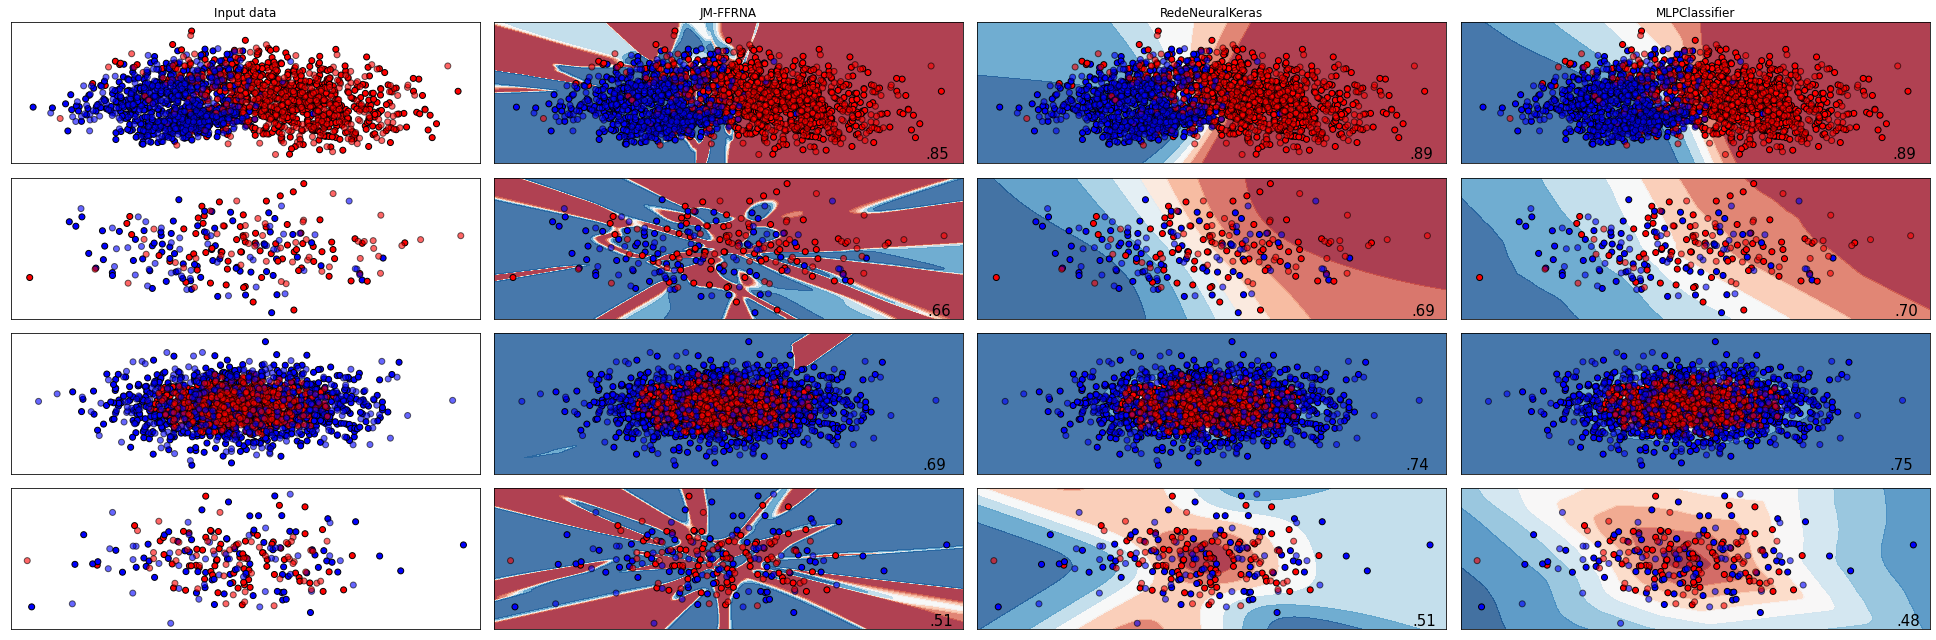

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

h = .02  # step size in the mesh
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
ds_cnt = 0
for dsn, ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    
    #passa a entrada pelo standard scaler
    X = StandardScaler().fit_transform(X)
    
    #após o standard scaler, passamos um PCA para pegar as duas características mais representativas
    X = PCA(n_components=2).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    
    if ds_cnt == 0:
        ax.set_title("Input data")
        
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for classifier in classifiers:
        name, clf = classifier
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
        
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1

    ds_cnt = +1
plt.tight_layout()
plt.show()

## Resultados e discussão da plotagem

Olhando os gráficos e tendo conhecimento das bases que geraram esses gráficos, podemos chegar à conclusão que esses métodos classificadores funcionam melhor conforme o número de amostras, como podemos ver na primeira e na terceira linhas, onde o score foi geralmente melhor.

Nas bases das linhas 2 e 3, há poucas amostras. Com isso, vemos que os resultados foram menos satisfatórios, o que é relativamente esperado uma vez que os métodos de redes neurais necessitam de uma grande quantidade de dados para realizar o treinamento.

Além disso, o tempo de treinamento continua elevado, o que também é esperado, uma vez que não foi utilizado o early stop ou ainda nenhuma heurística específica para função de custo que acelere o aprendizado em conjunto com early stop. As redes neurais implementadas e o MLPClassifier foram executadas apenas alterando-se o parâmetro de iterações ou épocas.

# Cross Validation usando os classificadores e as bases


In [16]:
def evaluate(datasets, classifiers, use_pca = True):
    df = pd.DataFrame()
    df_stats = []
    index = []
    stat_exemplo = {"min": 0, "max": 0, "mean": 0, "median": 0, "std": 0, "fit-time": 0}
    columns = []
    subcolumns = []
    for dsn, ds in datasets:
        ds_stats = []
        index.append(dsn)
        # preprocess dataset, split into training and test part
        X, y = ds

        #passa a entrada pelo standard scaler
        X = StandardScaler().fit_transform(X)

        #após o standard scaler, caso o parametro use_pca esteja com valor True, passamos um PCA para pegar as duas características mais representativas
        if use_pca:
            X = PCA(n_components = 2).fit_transform(X)

        for classifier in classifiers:
            name, clf = classifier
            
            #inicia o timer
            inicio = time.time()

            #realiza o cross validation com 5 folds
            scores = cross_val_score(clf, X, y, cv=5)

            #obtém o tempo de cross validation
            duracao = time.time() - inicio

            stats = {"min": 0, "max": 0, "mean": 0, "median": 0, "std": 0, "fit-time": 0}

            stats["fit-time"] = duracao
            stats["max"]      = np.max(scores)
            stats["min"]      = np.min(scores)
            stats["mean"]     = np.mean(scores)
            stats["median"]   = np.median(scores)
            stats["std"]      = np.std(scores)

            for key in stats:
                ds_stats.append(stats[key])

        df_stats.append(ds_stats)


    # iterate over classifiers
    for classifier in classifiers:
        name, clf = classifier
        columns.append(name)
    for key in stat_exemplo:
        subcolumns.append(key)

    header = pd.MultiIndex.from_product([columns, subcolumns], names=['classifier ->','statistics ->'])
    df = pd.DataFrame(df_stats, index = index, columns = header)
    return df

class PerformanceEvaluator():
    def __init__(self, X, y, kfold):
        self.kfold = kfold

        X_sparse = coo_matrix(X)
        self.X, X_sparse, self.y = shuffle(X, X_sparse, y)
        self.fold_scores = []
        self.stats = {"min": 0, "max": 0, "mean": 0, "median": 0, "std": 0, "fit-time": 0}

    def folds(self, clf):
        self.fold_scores = []
        start = time.time()
        for train_index, test_index in self.kfold.split(self.X, self.y):
            clf.fit(self.X[train_index],self.y[train_index])
            self.fold_scores.append(clf.score(self.X[test_index],self.y[test_index]))
        
        self.stats["fit-time"] = time.time() - start
        return self.fold_scores

    def evaluate(self, clf):
        folds = self.folds(clf)
        self.stats["max"]    = np.max(folds)
        self.stats["min"]    = np.min(folds)
        self.stats["mean"]   = np.mean(folds)
        self.stats["median"] = np.median(folds)
        self.stats["std"]    = np.std(folds)

class Experimenter():
    def __init__(self, kfold=KFold(5)):
        self.kfold = kfold
        self.datasets = []
        self.predictors = []
        self.stats = []
        self.df = pd.DataFrame()

    def addDataset(self, dataset):
        self.datasets.append(dataset)

    def addPredictor(self, predictor):
        self.predictors.append(predictor)

    def perform(self):
        dt = []
        index = []
        columns = []
        subcolumns = []
        pe = ""

        for dsn, X, y in self.datasets:
            pe = PerformanceEvaluator(X,y, self.kfold)
            stats = []
            for predname, pred in self.predictors:
                pe.evaluate(pred)
                for key in pe.stats:
                    stats.append(pe.stats[key])

            self.stats.append(stats)
            
            index.append(dsn)

        for predname, pred in self.predictors:
            columns.append(predname)
        for key in pe.stats:
            subcolumns.append(key)
        
        header = pd.MultiIndex.from_product([columns, subcolumns], names=['classifier ->','statistics ->'])
        self.df = pd.DataFrame(self.stats, index=index, columns=header)

## Resultado do cross validation com PCA

In [8]:
classifiers = [
    ("JM-FFRNA", RedeNeural([2, 40, 40, 1], epocas = 1000, debug = False)),
    ("RedeNeuralKeras", RedeNeuralKeras(epocas = 1000)),
    ("MLPClassifier", MLPClassifier(alpha = 1, max_iter = 1000)),
]

ds_pca = []
for dsn, ds in datasets:
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X = PCA(n_components = 2).fit_transform(X)
    ob = (dsn, (X, y))
    ds_pca.append(ob)

exp = Experimenter(kfold=KFold(5))

exp.addPredictor((classifiers[0][0], classifiers[0][1]))
exp.addPredictor((classifiers[1][0], classifiers[1][1]))
exp.addPredictor((classifiers[2][0], classifiers[2][1]))

exp.addDataset((ds_pca[0][0], ds_pca[0][1][0], ds_pca[0][1][1]))
exp.addDataset((ds_pca[1][0], ds_pca[1][1][0], ds_pca[1][1][1]))
exp.addDataset((ds_pca[2][0], ds_pca[2][1][0], ds_pca[2][1][1]))
exp.addDataset((ds_pca[3][0], ds_pca[3][1][0], ds_pca[3][1][1]))

#print("KFOLD MODE")
exp.perform()
exp.df

classifier ->  JM-FFRNA                      ... MLPClassifier                    
statistics ->       min       max      mean  ...        median       std  fit-time
Base 1         0.857500  0.897500  0.875000  ...      0.885000  0.015050  4.005254
Base 2         0.458333  0.645833  0.579167  ...      0.645833  0.035843  0.574014
Base 3         0.732500  0.777500  0.756000  ...      0.757500  0.017364  4.053231
Base 4         0.458333  0.604167  0.537500  ...      0.562500  0.037268  0.697737

[4 rows x 18 columns]

## Resultado do cross validation sem PCA

In [23]:
classifiers = [
    ("JM-FFRNA", RedeNeural([2, 40, 40, 1], epocas = 1000, debug = False)),
    ("RedeNeuralKeras", RedeNeuralKeras(epocas = 1000)),
    ("MLPClassifier", MLPClassifier(alpha = 1, max_iter = 1000)),
]

ds_aux = []
for dsn, ds in datasets:
    X, y = ds
    X = StandardScaler().fit_transform(X)
    ob = (dsn, (X, y))
    ds_aux.append(ob)

exp = Experimenter(kfold=KFold(5))

exp.addPredictor((classifiers[0][0], classifiers[0][1]))
exp.addPredictor((classifiers[1][0], classifiers[1][1]))
exp.addPredictor((classifiers[2][0], classifiers[2][1]))

exp.addDataset((ds_aux[0][0], ds_aux[0][1][0], ds_aux[0][1][1]))
exp.addDataset((ds_aux[1][0], ds_aux[1][1][0], ds_aux[1][1][1]))
exp.addDataset((ds_aux[2][0], ds_aux[2][1][0], ds_aux[2][1][1]))
exp.addDataset((ds_aux[3][0], ds_aux[3][1][0], ds_aux[3][1][1]))

#print("KFOLD MODE")
exp.perform()
exp.df

classifier ->  JM-FFRNA                      ... MLPClassifier                     
statistics ->       min       max      mean  ...        median       std   fit-time
Base 1         0.847500  0.870000  0.857500  ...      0.880000  0.013172  14.038827
Base 2         0.604167  0.812500  0.708333  ...      0.812500  0.030619   4.548363
Base 3         0.955000  0.977500  0.968000  ...      0.970000  0.007246  10.732769
Base 4         0.437500  0.604167  0.508333  ...      0.583333  0.067700   4.522943

[4 rows x 18 columns]

# Avaliação Final

Conforme o resultado já discutido na plotagem dos gráficos, os melhores resultados do cross validation com e sem PCA estão nas bases 1 e 3, devido ao grande número de amostras que estas bases possuem.

Nesta avaliação, julgamos que não deve ser observado o desempenho apenas, mas sempre em comparação com as demais implementações, pois não foi feito trabalho de ajuste de nenhum hiperparametro, em nenhum dos 3 classificadores.

## Com PCA
Se considerarmos a média (coluna "mean") dos dataframes, podemos observar que no geral a implementação ingênua de rede neural feed forward teve um desempenho pior que a implementação ingênua usando o keras e o MLPClassifier para as bases. O destaque fica para o tempo de fit que sem ajustes como early stop, ou melhores funções de custo, acabam prejudicando a implementação da rede neural feed forward.

## Sem PCA
Se considerarmos a média (coluna "mean") dos dataframes, podemos observer que o resultado é um pouco parecido com a seção "Com PCA", o tempo de fit da nossa rede neural feed forward continua sendo o maior, porém aqui, o resultado está mais próximo dos outros em algumas situações, como bases 1 e 3. Nas bases 2 e 4 essa distancia aumenta um pouco.